BO function:

Input: 
df-contains all previous data, include newly tested ones and training set

Output:
new (x) composition: e.g. (1, 5, 27, 67)


BO properties:
- sample space: 4 -> K, Na, Cs, Li
- mixing resolution: 1%
- Noise level: 5% (error from the sensor)


Physical layer workflow:

initialization (activate the cell) K
calibration (calibrate the sensor) Na
find the calibrated line

BO(based on training data, make the first suggestion)-> comp 1

runcell (comp 1) -> 7000PPB

calibrate result(7000PPB) -> generate new PPB

label the new data point that was tested

cleaning()

BO(updated df with new label) -> suggest new comp

runcell(*new comp from BO)

repeat...




Dragon bless, No bug
        ,  ,
          \\ \\           
          ) \\ \\    _p_ 
          )^\))\))  /  *\ 
           \_|| || / /^`-' 
  __       -\ \\--/ / 
<'  \\___/   ___. )'
     `====\ )___/\\ 
          //     `"
          \\    /  \


In [2]:
import pandas as pd
import numpy as np
import itertools
import torch
from botorch.models import SingleTaskGP
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.constraints import GreaterThan, Interval
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from scipy.stats import norm
from botorch.acquisition.analytic import ExpectedImprovement
import matplotlib.pyplot as plt
import warnings
import random
from gpytorch.likelihoods import GaussianLikelihood
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr
import time
import os
import argparse
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
import ast
import re
import pandas as pd
import warnings
from sklearn.preprocessing import StandardScaler
from itertools import permutations

In [20]:
def search_space_cons(n_components, names, resolution):
    
    if len(names) != n_components:
        raise ValueError("Length of 'names' must match 'n_components'.")

    levels = int(1 / resolution) + 1
    grid = itertools.product(range(levels), repeat=n_components)
    
    mixtures = [tuple(xi * resolution for xi in combo)
                for combo in grid if abs(sum(xi * resolution for xi in combo) - 1.0) < 1e-8]
    
    df = pd.DataFrame(mixtures, columns=names)
    df = (df * 100).astype(int)
#     df['mixture_id'] = df[names].apply(lambda row: tuple(row), axis=1)
    return df


def bo_run(data_dir, nb_iterations, df_initial, which_acquisition, 
           store_explore_exploit_terms=True, seed_number = 42, noise_ratio = 0.05):
    
    assert nb_iterations >= nb_mix_initialization
    assert which_acquisition in ['max y_hat', 'EI', 'max sigma']

    # reading data
    resolution = 0.01
    search_space_cons_status = False
    if search_space_cons_status:
        df = search_space_cons(4, ['K', 'Na', 'Cs', 'Li'], resolution)
    else:
        df = pd.read_csv(data_dir)
    
    nb_mix = len(df.index)
    df['mixture_id'] = df[['K', 'Na', 'Cs', 'Li']].apply(lambda row: tuple(row), axis=1)
    df_initial['mixture_id'] = df_initial[['K', 'Na', 'Cs', 'Li']].apply(lambda row: tuple(row), axis=1)
    lookup = {v: i for i, v in df['mixture_id'].items()}
    ids_acquired = df_initial['mixture_id'].map(lookup).to_numpy()

    df.loc[ids_acquired, 'FE'] = df_initial['FE'].values
    df_X = df.drop(columns=['FE', 'mixture_id']).astype('float64')
    df_y = df['FE']     
    
    if which_acquisition == "EI" and store_explore_exploit_terms:
        explore_exploit_balance = np.array([(np.NaN, np.NaN) for i in range(nb_iterations)])
    else:
        explore_exploit_balance = []
        
    for i in range(nb_mix_initialization, nb_iterations):
        print("iteration:", i, end="\r")

        X = torch.from_numpy(np.array(df_X))
        y = torch.from_numpy(np.array(df_y))
        y = y.unsqueeze(1)
        X_unsqueezed = X.unsqueeze(1)


        noisy_exp = True
        if noisy_exp:
            noise_std = noise_ratio * y  # 5% of the measurement as std
            yvar = noise_std ** 2  # variance = std^2

        # initialize acquired y, since it requires normalization
        y_acquired = y[ids_acquired]
        X_acquired = X[ids_acquired]
        yvar_acquired = yvar[ids_acquired]
        
        # standardize outputs using *only currently acquired data*
        y_acquired = (y_acquired - torch.mean(y_acquired)) / torch.std(y_acquired)

        model = SingleTaskGP(X_acquired, y_acquired, train_Yvar=yvar_acquired)        
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll) 
        
        # set up acquisition function
        if which_acquisition == "EI":
            acquisition_function = ExpectedImprovement(model, best_f=y_acquired.max().item())
            acquisition_values = acquisition_function.forward(X_unsqueezed) 
        elif which_acquisition == "max y_hat":
            with torch.no_grad():
                acquisition_values = model.posterior(X_unsqueezed).mean.squeeze()
        elif which_acquisition == "max sigma":
            with torch.no_grad():
                acquisition_values = model.posterior(X_unsqueezed).variance.squeeze()
        else:
            raise Exception("not a valid acquisition function")

        # select sample to acquire with maximal aquisition value, which is not in the acquired set already
        ids_sorted_by_aquisition = acquisition_values.argsort(descending=True)
        for id_max_aquisition_all in ids_sorted_by_aquisition:
            if not id_max_aquisition_all.item() in ids_acquired:
                id_max_aquisition = id_max_aquisition_all.item()
                break

        # if EI, compute and store explore-exploit terms that contribute to EI separately.
        if which_acquisition == "EI" and store_explore_exploit_terms:
            # explore, exploit terms of EI. requires computing EI manually, essentially. 
            y_pred = model.posterior(X_unsqueezed[id_max_aquisition]).mean.squeeze().detach().numpy()
            sigma_pred = np.sqrt(model.posterior(X_unsqueezed[id_max_aquisition]).variance.squeeze().detach().numpy())
            y_max = y_acquired.max().item()
            z = (y_pred - y_max) / sigma_pred
            # print(sigma_pred)
            # print(z)
            explore_term = sigma_pred * norm.pdf(z)
            exploit_term = (y_pred - y_max) * norm.cdf(z)
            # check we computed it right... i.e. that it agrees with BO torch's EI.
            assert np.isclose(explore_term + exploit_term, acquisition_values[id_max_aquisition].item())

            explore_exploit_balance[i] = (explore_term, exploit_term)

            
            
################################################################################################################

# Part need to be completed by Wilson
        
    
        sample_to_run = X[id_max_aquisition]
        #Run the system for labelling sample_to_run --> 
        df_y.loc[id_max_aquisition] = 50* np.random.uniform(0, 1, 1) # should be removed (only for testing the code) 
        ids_acquired = np.concatenate((ids_acquired, [id_max_aquisition])) 
################################################################################################################

        
        plt.figure()
        plt.plot(df_y.loc[ids_acquired].values, marker='o')  
        plt.axhline(y=10, linestyle='--', color='gray')
        plt.title(f'Iteration {i}')
        plt.xlabel('Index')
        plt.ylabel('FE')
        plt.show()      # or plt.pause(1) to show it for a short time
        plt.close()
        
        
        y = torch.from_numpy(np.array(df_y))
        y = y.unsqueeze(1)
        y_acquired = y[ids_acquired] # start over to normalize y properly
        y_acquired = (y_acquired - torch.mean(y_acquired)) / torch.std(y_acquired)
        
    return df_X, df_y, ids_acquired, explore_exploit_balance


def main(nb_iterations, df_initial, which_acquisition, patience, 
        experiment_name, save_plot=True, i = 1, seed_number = 42, base_dir = '../data/TF',
        data_dir = '../data/df.csv'):
    
    # RUN TRAINING
    which_acquisition = "EI"

    print("# Mixtures in initialization:", nb_mix_initialization)
    # store results here.
    bo_res = dict() 
    bo_res['ids_acquired']            = []
    bo_res['explore_exploit_balance'] = []
    store_explore_exploit_terms = True

    print("\nRUN Started")
    t0 = time.time()

    df_X, df_y, ids_acquired, explore_exploit_balance = bo_run(data_dir, nb_iterations, df_initial, which_acquisition, 
       store_explore_exploit_terms=True, seed_number = 42, noise_ratio = 0.05)

    # store results from this run.
    bo_res['ids_acquired'].append(ids_acquired)
    bo_res['explore_exploit_balance'].append(explore_exploit_balance)

    print("took time t = ", (time.time() - t0) / 60, "min\n")

    df = pd.concat([df_X, df_y], axis = 1)
    df.to_csv('../Results/df.csv', index = True)
    

    return df, ids_acquired

1
# Mixtures in initialization: 5

RUN Started


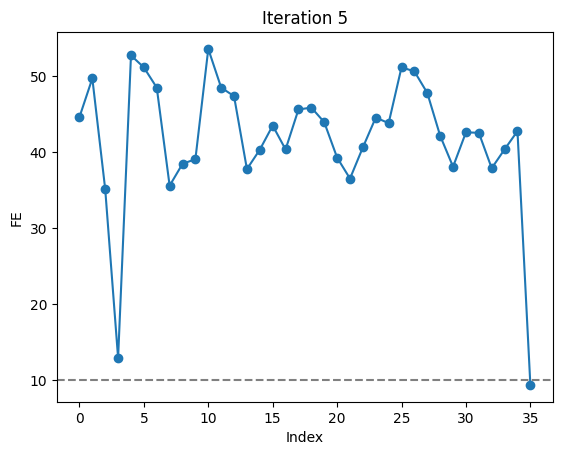

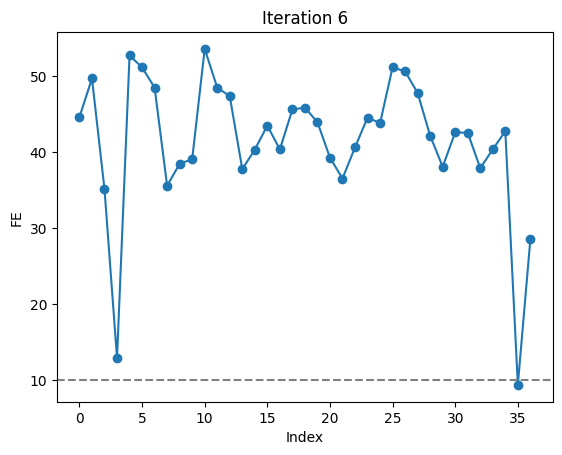

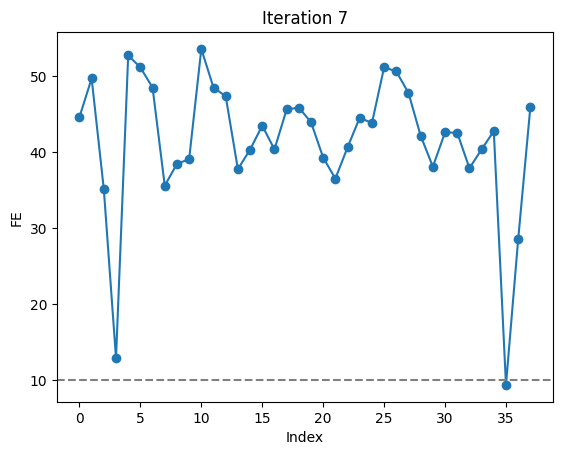

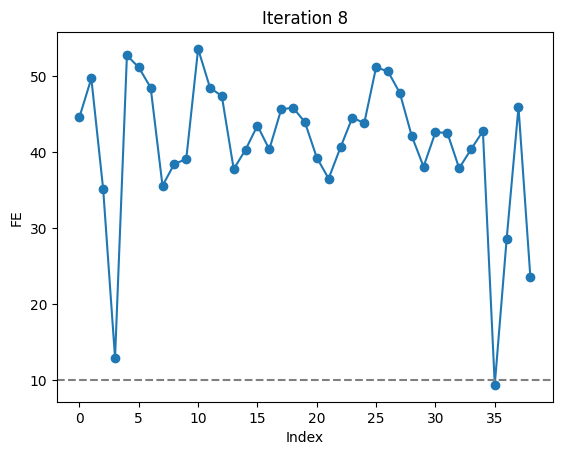

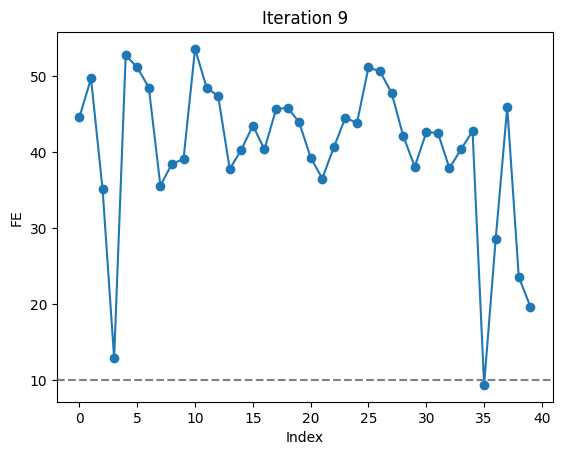

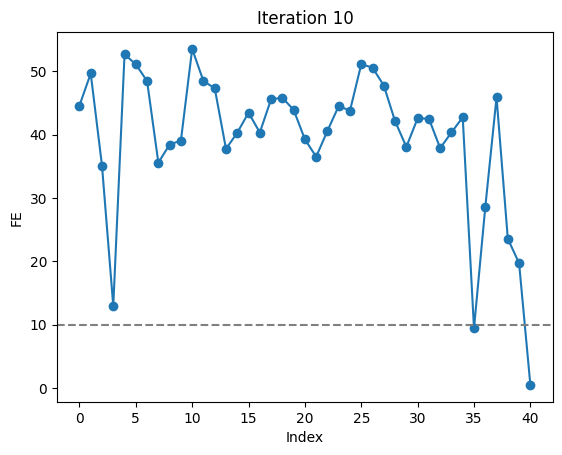

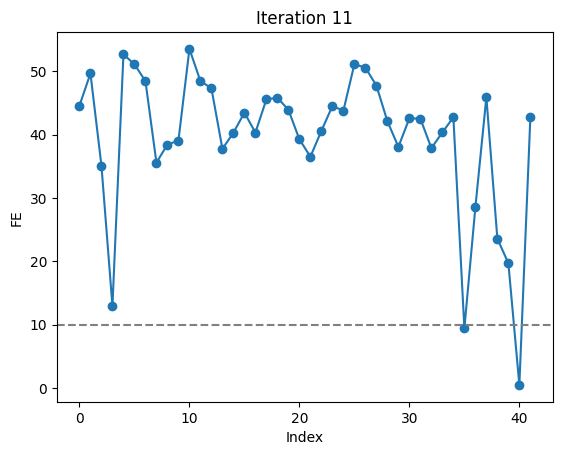

KeyboardInterrupt: 

In [21]:
warnings.filterwarnings('ignore')

base_dir = '../data/'
Run_Info = "TF_mord_mean" # + "_" + "2/3/4"
nb_iterations = 20 #*
nb_mix_initialization = 5 #**
nb_runs = 1
patience = 3
which_acquisition = "EI"
save_plot = True
n_seed = 1
df_initial = pd.read_excel('../data/df_initial.xlsx')

experiment_name = '1'
print(experiment_name)
df, ids_acquired = main(nb_iterations, df_initial, which_acquisition, patience, experiment_name)

    